OSE scentific computation final report  WS 2020/2021 Bonn University
Title
author: Po-Tse Cheng

In [1]:
# import custom functions
from tools.auxiliary import*
from tools.GSSA_1_agent import*
from tools.GSSA_countries import*

In [7]:
# todo 
#- recomment the comments
# change some wordings, so many "followings"

What you can expect in this notebook:

- All of the matlab codes from the original authors have been translated into python, including Appendix.
- Besides of the representitive agent model, a multicountry model purposed by the paper is also implemented in python.
- Instead of presenting the results in merely tables, I construct figures as they are more intuitive in my opinion.

What is the caveat:

- Two proximation methods included in GSSA, namely LAD-DP and RLAD-DP is not implemented

This notebook contains the python implementation of the General Stochastic Simulation Algorithm (GSSA), developed by Kenneth L. Judde et. al (2011). 

## Introduction

A better text here
There are three mainstream methods for solving a dynamic stochastic economics model: projection methods, perturbation methods, and stochastic simulation methods. Each of these methods have 

We will be focusing on the stochastic model with the goal of 

-----
Work in process: Maybe it make sense to first talk about the GSSA then look at the stuff of stability and accuracy
This notebook is constructed as the following: We will first look at the theorethical background for stochastic model, including potential solution of addressing the undesired properties. Then we will take a closer look at GSSA's mechanisms. In chapter 4, we will showcase the GSSA in a multi-country framework. Lastly, we conclude this notebook in chapter 5.

## Background

In this section, we will first set up a classical representitive agent model to further discuss the advantages of stochastic simulation methods. We will then show the mechanism of PEA, and further discuss how GSSA evolves and surpass the precursor.

### The Representitive Agent Model

Consider an agent that faces intertemporal utility-maximisation problem:

\begin{align*}



\max_{\{k_{t+1}, c_{t}\}_{t=0,...,\infty}}&E_{0}\sum^{\infty}_{t=0}\beta^{t}u(c_{t}) \tag{1} \\
s.t.\quad &c_{t}+k_{t+1}=(1-\delta)k_{t}+a_{t}f(k_{t}), \tag{2}\\
&\ln a_{t+1}=\rho\ln a_{t}+\epsilon_{t+1}, \epsilon_{t+1}\sim \mathcal{N}(0,\,\sigma^{2}) \tag{3}\\
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1}) [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \tag{4}


\end{align*}

  Where $u(\boldsymbol{\cdot})$ represents the utility function, $E_{t}$ on the other hand denotes the expectation operator for the information given at time $t$.  $c_{t}$, $k_{t}$, $a_{t}$ stands for consumption, capital, and productivity level respectively. $f(\boldsymbol{\cdot})$ describes the production function. $\beta \in (0,1)$ denotes the discount factor; while $\delta \in (0,1]$ and $\rho \in (-1,1)$ represents depreciation of capital and autocorrelation coefficient of the productivity level. $\sigma \geq 0$ stands for the standard deviation of the productivity shock. Notice that during $t=0$ both $k_{0}$ and $a_{0}$ are given. The solution to the stochastic model needs to satisfy the Euler equation (4), while also both transition equations (2) (3). Our objective will be trying to obtain both policy and consumption function, which denotes as $K(\boldsymbol{\cdot})$, $C(\boldsymbol{\cdot})$. Both solutions also need to be able to represent as a Markov equilibrium such that $k_{t+1}= K(k_{t},a_{t})$ and $c_{t}=C(k_{t}, a_{t})$.

### Why Stochastic Simulation Models?

The biggest advantage of using stochastic simulation method is it only considers solutions that are part of the state space that is visited in equilibrium. In other words, solutions can only be from the space created by simulations, which translate into a higher probability to be the right answers. Taking the closed-form solutions from the representitive agent model, we can see that in Figure (1) the ovel shape from the solutions does not occupy the whole rectangular space. To be even more precise, the solutions take around 79% of the space or 21% smaller than the original space.

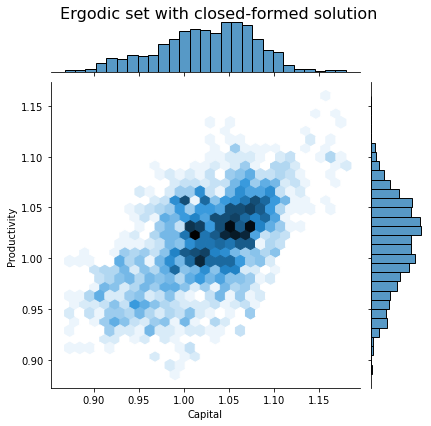

In [2]:
Figure1()

This occupying ratio quickly decreases as the dimension increases. Consider $\nu^{d}$ denotes the ratio of a $d$-dimensional hypersphere to $d$-dimensional hypercube with both diameter set to 1. The general form of the ratio can be express as follow:

\begin{align*}
\nu^{d}=
\begin{cases}
      \frac{(\pi/2)^{(d-1)/2}}{1\cdot3\cdot,...,d} & \text{for $d=1,3,5,...$}\\
      \frac{(\pi/2)^{d/2}}{2\cdot4\cdot,...,d} & \text{for $d=2,4,6,...$}\\
\end{cases}     
\end{align*}

We can observe that the ratio $\nu^{d}$ decrease rapidly with the increase of dimension. Stochastic simulation methods therefore have the advantage of not calculating the whole sets of potential candidates, which translate into lower computational cost. The larger the dimension, the larger the cost save. Another great perk is that given the model only consider relevant domain, via fitting the polynomials one is able to achieve great accuracy than conventional projection methods. Maliar et al.(2010) further provide evidence to the latter claim.

### Problems with Stochastic Methods

Despite the promising theoretical perspectives, most conventional simulation models have disappointing results in real practices. Not only are they not able to obtain high accuracy as projection methods, it is also difficult for them to reach numerical stability in higher polynomials. Let us consider a generic stochastic algorithm for model solving:
<ol>
 <li>Guessing the policy or value function</li>
 <li>Simulate the time series solution</li>
 <li>Use simulated solution to recompute the guess</li>
 <li>Repeat 2 and 3 until converge</li>
</ol>
Notice that during step 3 the algorithm will do both regression approximation and intergration, as the former aims to fix an approximate function while the latter evalutes the conditional expectations. It is also during this step where the weaknesses are formulated. Simulation methods often suffer from low numerical stability, namely it is difficult for the calculated solutions to converge. The authors further point out the unstability is the side effect of the the high correlation among the polynomial degrees. This means standard least square methods are likely to fail due to low stability. Poor accuracy stems from traditional Monte-Carlo integration method, as Judd et al.(2011) shows more promising accuracy if one choose alternative methods such as Gauss-Hermite.

### From PEA to GSSA

After discussing the potential strengths and weekness of simulation methods, let's refocus on how simulation methods approach the representative agent problem. In particular, we will be focusing on the Parameterized Expectations Algorithm (PEA) by Marcelt et al. (1988). PEA serves as the precursor the GSSA, and most importantly take advantage of ergodic solutions. It proceeds as following:

1. Construct a flexible functional form from equation (4)
* Notice that the $b$ below are a series of approximate coefficients for the real function, that we wish to obtain
\begin{align*}
u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_t+1)[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \equiv \psi(k_{t}, a_{t}; b)= \exp (b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l}) \tag{5}
\end{align*}
2. Plug equation (5) into to equation (2) to express future capital $k_{T+1}$
\begin{align*}
k_{t+1} \equiv (1-\delta)k_{t}+ a_{t}f(k_{t})-\frac{1}{u^{'}}[\psi(k_{t}, a_{t}; b)]  \tag{6}
\end{align*}
3. Simulate the set $\{c_{t}, k_{t+1}\}_{t=0,...,T}$ with equation (6), where $T$ stands for the simulation length
* Fix $b$ to some abitrary set
* $\{a_{t}\}_{t=1,...,T}$ is pre-defined
\begin{align*}
y_{t} \equiv \beta u^{'}(c_{t+1}) [1-\delta+ a_{t}f^{'}(k_{t+1})] \tag{7}
\end{align*}
4. By combining equation (7) and (5) we can get $y_{t}=\psi(k_{t}, a_{t}; b)+\epsilon$, employ nonlinear least square regression to solve $\hat b$
5. compute the next iteration input $b^{(p+1)}$ with fix-point iteration
* $\zeta$ is the damping parameter, where $\zeta \in (0,1]$
\begin{align*}
b^{(p+1)}=(1-\zeta)b^{(p)} + \zeta \hat b \tag{8} 
\end{align*}

PEA suffers from the exact two afore-mentioned drawbacks. Firstly, in theory PEA is able to handle high polynomials in equation (5), the outputs however are generally numerically unstable. We can see this by going through the later work of Marcet, where he removes $b_{5}\ln k_{t} \ln a_{t}$ in the 2nd polynomial term in order to achieve convergent. Secondly, the accuracy of PEA is low, namely the accuracy does not increase with higher polynomials. The goal of the GSSA, is to overcome these two obstacles at once, as it is waste of effort increasing the numerical stability of higher polynomials if they do not yield better accuracy, while there is also no point of attaining a higher accuracy in higher polynomials if it is not numerically stable. Let us now examine the difference of equation (5) in GSSA compared to PEA. Instead of incorporating the original exponential $\psi$, GSSA uses the flexible functional form as the following:

\begin{align*}
\psi(k_{t}, a_{t}; b)=  b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l} \tag{9}
\end{align*}

The main reason to abandon the original non-linear method is to reduce the complexity of obtaining $b$, while simultaneously introducing other regression methods that are capable of handling collinear data. This approach can drastically improve the numerical stability. Under the GSSA framework, LS methods using singular value decompsition (SVD) and least-absolute deviations (LAD) are possible. GSSA are also design in such a way that one can simply switch between integration methods. In section ?, we will see that the results of Monte-Carlo are indeed unremarkable.

So how do we solve the 1 agent problem with GSSA? We will be using 2 particular tools to obtain our solutions. Similar to Marcet et al. (1988), we will incorporate the flexible functional form $\psi(\boldsymbol{\cdot} ;b)$ to approximate the original policy function $K(\boldsymbol{\cdot})$. $K(\boldsymbol{\cdot})$ is therefore expressed with:

\begin{align*}
\psi(k_{t}, a_{t}; b) \approx K(k_{t},a_{t})=k_{t+1} \tag{10}
\end{align*}

Now consider the second tool: Fixed point construction. Via rewriting equation (4), we obtain the follows:

\begin{align*}
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1})[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv  1=E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv k_{t+1}= E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]k_{t+1}\} \tag{11}
\end{align*}

Given that the first derivative of utility function $u^{'}(c_{t})$ in the Euler equation can never be 0, equation (10) holds under any condition. By combining both equation (10) and equation (11) (by subtitution), we will be able to solve the stochastic model by computing the conditional expectation.

## Mechanisms of GSSA

In this section, we will look into the mechanisms of the GSSA. Following the original authors, we will break down the whole algorithm into two parts: Stage 1 and Stage 2. The purpose of Stage 1 aims to find suitable candidates, while Stage 2 conducts the accuracy test by using a new set of test points (can be another set of random draw or deterministic set of points) independent to the solution.

### GSSA Stage 1

1. Initialisation

* Parameters set up 
* Initial states for $k_{0}$ and $a_{0}$
* Define simulation length $T$

2. At iteration $p$ Use $b^{(p)}$ to simulate the model for $T$ periods, in this case it is capital $k_{t+1}$ and consumption $c_{t}$ as describe in the markov equilibrium
* Capital
\begin{align*}
k_{t+1}=\psi(k_{t},a_{t};b^{(p)})
\end{align*}

* Consumption
\begin{align*}
c_{t}=(1-\delta)k_{t}+ a_{t,j}f(k_{t})-k_{t+1,j}
\end{align*}


3. Define $y_{t}$ to be the approximation of conditional expectation in equation (11) with given $J$ integration nodes $\{\epsilon_{t+1,j}\}_{j=1,...,J}$ and weights $\{\omega_{t+1,j}\}_{j=1,...,J}$

\begin{align*}
y_{t}= \sum^{J}_{j=1}\{\omega_{t,j}\cdot(\beta\frac{u^{'}(c_{t+1,j})}{u^{'}(c_{t})}[1-\delta + a_{t+1,j}f^{'}(k_{t+1}) ]k_{t+1}) \}
\end{align*}


Notice that $a_{t+1,j}$, $k_{t+2,j}$, and $c_{t+1,j}$ are calculated as following:
\begin{align*}
a_{t+1,j} &= a^{\rho}_{t}exp(\epsilon_{t+1,j}) \\


k_{t+2,j} &\equiv \psi(k_{t+1}, a^{\rho}_{t}exp(\epsilon_{t+1,j});b^{(p)} ) \\

c_{t+1,j} &= (1-\delta)k_{t+1}+ a_{t+1,j}f(k_{t+1})-k_{t+2,j}
\end{align*}


4. Find the $\hat b$ that minimise the error term with chosen approximation method, depending on whether if it is the initial guess or updating the solution
\begin{align*}
y_{t}=\psi(k_{t},a_{t};b)+\epsilon_{t} \tag{12}
\end{align*}

5. Check convergence, jump out of stage one if satisfied
\begin{align*}
\frac{1}{T}\sum^{T}_{t=1}|\frac{k^{(p)}_{t+1}-k^{p-1}_{t+1}}{k^{(p)}_{t+1}}| < \varphi
\end{align*}


Where the D inside the code denotes the polynomial degree and kdamp stands for damping parameter for iteration on the coefficients of the capital policy functions. The convergence parameter $\varphi$ depends on both values. @rewrite

6. Compute $b^{p+1}$ for the next iteration similar to equation (8)
\begin{align*}
b^{(p+1)}=(1-\zeta)b^{(p)} + \zeta \hat b 
\end{align*}

<div class="alert alert-block alert-success">
<b>Side note:</b> Notice that within Stage 1, GSSA will first employ a 1-node Monte Carol intergration method for the initial guessing. Afterwards, within the scope of Stage 1, GSSA will update the solution with regards to each polynomial based on the selected regression method, integration method, and polynomials.
</div>

### GSSA stage 2

The stage 2 of GSSA is a self-contained benchmarking stage for the results from stage 1, to ensure the results only have errors with low economical impact. Stage 2 measures both the unit-free maximum and mean errors with another independent set of simulations or deterministic set. The prerequisite will be that the number of testing samples $T^{test}$ needs to be either equal or larger than the original simulation $T$. Let us denote the new testing set as $\{a_{i},k_{i}\}_{i=1,...,T^{test}}$, and the theoretical notation for stage 2 is as follows:
\begin{align*}
\epsilon_{k_{i},a_{i}}=E_{i}\{\beta\frac{u^{'}(c_{i+1})}{u^{'}(c_{i})}[1-\delta+a_{i+1}f^{'}(k_{i+1})]\}-1
\end{align*}
One can immediately see that the test itself is another manupulation of the original Euler equation (4).

### GSSA result showcase

I will now demonstrate the results from using GSSA. In this scenario, I set the length of simulation to 10000 observations and choose RLS-TSVD as my regression method. Furthermore, I pick 10-node Gauss-Hermite quadrature as my integration methods. The accuracy from stage 2 are measured by 10200 observations independently. Below are the results:

In [2]:
showcase_result = GSSA_ShowcaseResult()
showcase_result

,Maximum Error,Mean Error,Time,Error Time,Polynomial Degree,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
0,-3.366134,-4.358702,29.380091,0.686520,1,30.066611,30.07,4.378225e-05,4.303938e-04
1,-4.883611,-6.118154,46.610950,0.825667,2,47.436617,47.44,7.618090e-07,1.307343e-05
2,-5.951989,-7.481158,71.307241,0.887692,3,72.194934,72.19,3.302497e-08,1.116891e-06
3,-7.021109,-8.716910,99.593968,0.929680,4,100.523648,100.52,1.919067e-09,9.525574e-08
4,-7.178640,-8.893005,139.285022,1.226172,5,140.511194,140.51,1.279368e-09,6.627663e-08


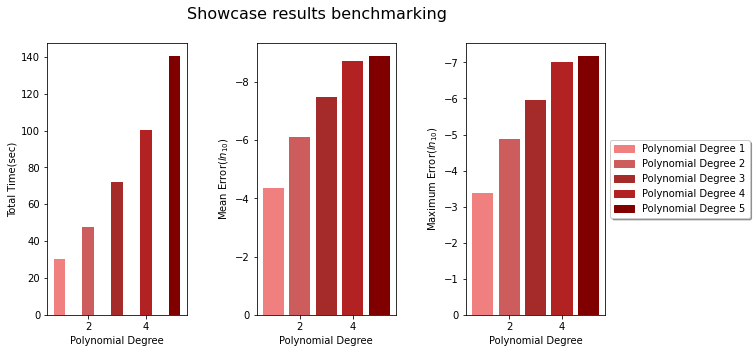

In [3]:
Figure3(showcase_result)

The results of the final output is remarkable. We can see that the accuracy increase with the polynomials

Not only does it achieve an astonishing average $10^{-9}$ in polynomial degrees 4 and 5, there are no longer an 

<div class="alert alert-block alert-success">
<b>Short conclusion:</b> These results further confirm that GSSA overcome the two main problems from the original PEA: (1) numerical instability and (2) low accuracy in higher polynomials.
</div>

## Weakness Identifying and Solving

### Ill-conditioned LS problems

We will briefly discuss the stability issues from the standard regression methods. We will first rewrite equation (9) into the following:

\begin{align*}
\psi(k_{t},a_{t};b) = \sum^{n}_{i=0}b_{i}\psi_{i}(k_{t},a_{t})
\end{align*}

which combining with equation (12) in the first stage of GSSA implies the following equation:

\begin{align*}
y = Xb+\epsilon
\end{align*}



We can obtain the estimator $\hat b$ with:
\begin{align*}
\hat b = (X^{T}X)^{-1}X^{T}Y
\end{align*}
- Scaling




- Multiasfasd

### Stability enhancement:

#### LS approach

GSSA uses 

In [2]:
# One can of course change the True to False here, the code should have no problem running through.
# It will take some time though.
result1, result2, result3 = Result_agent(cache=True)

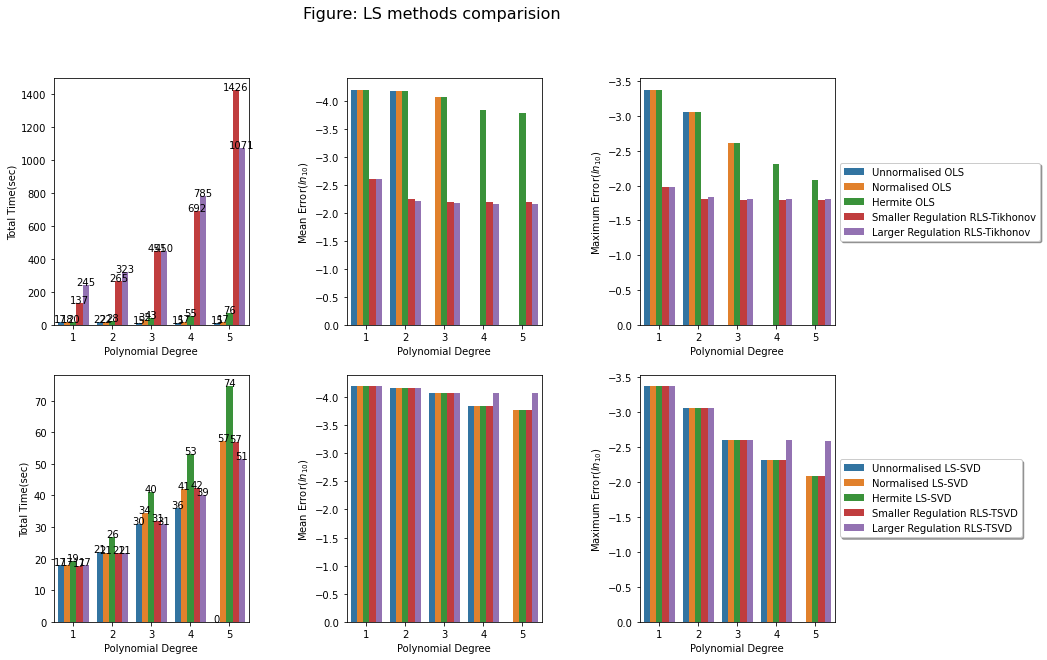

In [3]:
LS_Figure(result1, result2)

#### LAD approach

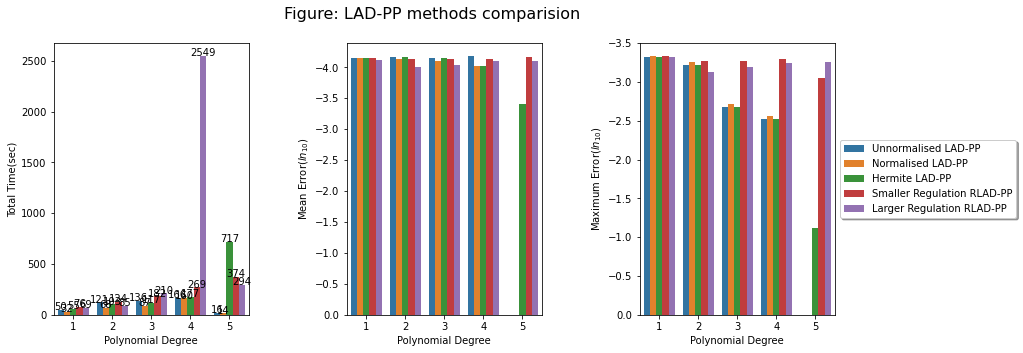

In [4]:
LAD_figure(result3)
# need to clean the time of unnormalised and normalised

#### Other factors (Polynomial types):

Another that could potentially affects the stability are the choice 

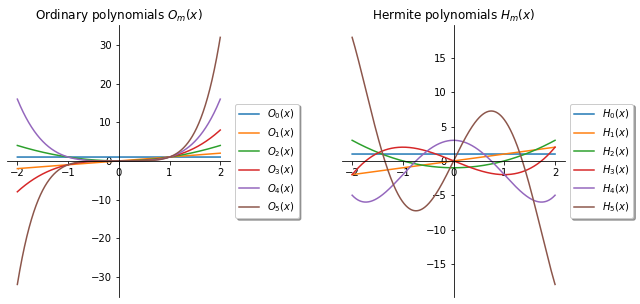

In [3]:
Figure2()

We have shown already in that asfasfs

### Accuracy integration

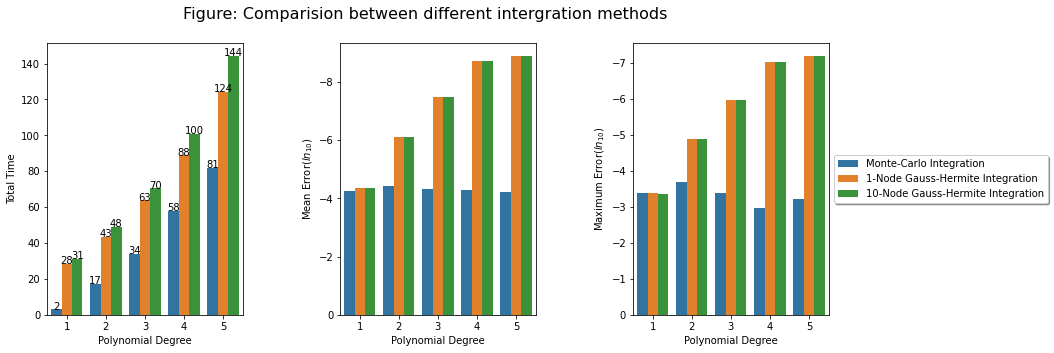

In [2]:
Figure4()

### Country implementation

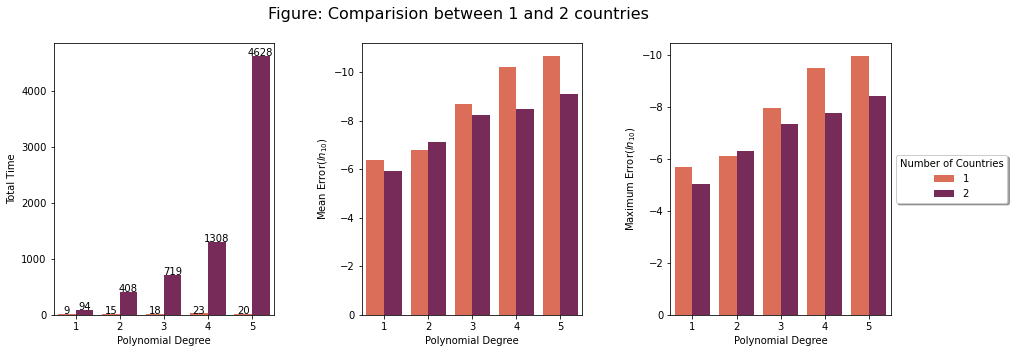

In [4]:
country_Figure1()

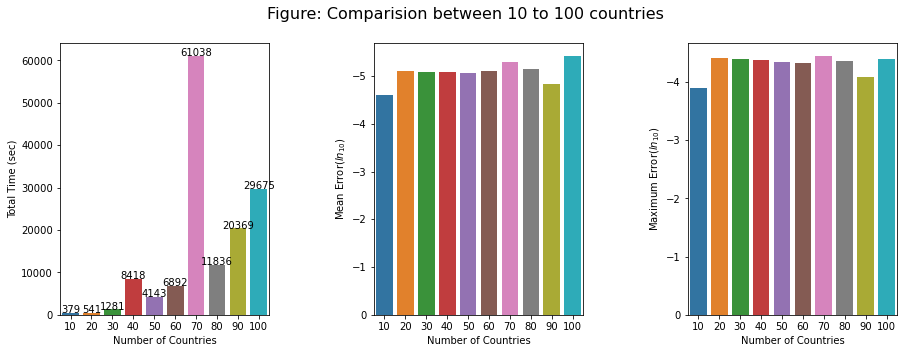

In [2]:
country_Figure2()

### Conclusion

### Reference

Maliar, L., & Maliar, S. (2003). Parameterized Expectations Algorithm and the Moving Bounds. Journal of Business & Economic Statistics, 21(1), 88-92.

Den Haan, W. J., & Marcet, A. (1990). Solving the stochastic growth model by parameterizing expectations. Journal of Business & Economic Statistics, 8(1), 31-34.

Judd, K., Maliar, L., & Maliar, S. (2011). One-node quadrature beats Monte Carlo: a generalized stochastic simulation algorithm (No. w16708). National Bureau of Economic Research.